<a href="https://colab.research.google.com/github/dimidagd/gists/blob/main/Vision_transformers_patching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q --upgrade yt-dlp
!apt -y install ffmpeg lame
!yt-dlp --verbose 'https://www.youtube.com/watch?v=CoL8Gtvxfl0' --download-sections "*3-7" -f mp4 -o './sample_video_dog.mp4'

In [ ]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/train'
! ls 'IMagenet/tiny-imagenet-200/train/n01443537/images' | wc -l

In [114]:
import torch.nn as nn
import torch
from itertools import repeat

from PIL import Image
from torchvision import transforms
import os
from tqdm.notebook import tqdm

In [116]:
# Taken from https://github.com/facebookresearch/dinov2/blob/e1277af2ba9496fbadf7aec6eba56e8d882d1e35/dinov2/eval/segmentation_m2f/models/backbones/vit.py#L112


def to_2tuple(x):
    return tuple(repeat(x, 2))


class PatchEmbed(nn.Module):
    """2D Image to Patch Embedding."""

    def __init__(
        self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=None, flatten=True, bias=True
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size, bias=bias)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        x = self.norm(x)
        return x, H, W


In [117]:
X = torch.rand(1,3,224,224)
Z, H ,W = PatchEmbed()(X)
print(Z.shape,H,W)
print("B 14*14 embed_dim")

torch.Size([1, 196, 768]) 14 14
B 14*14 embed_dim


In [118]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')
dinov2_vitl14 = dinov2_vitl14.to(device)
patch_size = dinov2_vitl14.patch_size # patchsize=14

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [119]:
# Defines the output resolution
n_patches = 10

In [120]:

n_patches_h, n_patches_w =  int(n_patches), int(n_patches)
patch_h  = patch_size*n_patches_h//patch_size
patch_w  = patch_h

transform = transforms.Compose([
                                transforms.Resize(2*patch_size*n_patches),
                                transforms.CenterCrop(patch_size*n_patches), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                ])

#520//14

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

class_id = "n01629819"
folder_path = f'IMagenet/tiny-imagenet-200/train/{class_id}/images'
total_features  = []
n_frames = 4

with torch.no_grad():
  for img_path in tqdm(os.listdir(folder_path)[0:n_frames]):
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).to(device)

    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([4, 100, 1024])

In [121]:
def get_video_dimensions(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # Get the width and height of the video frames
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Release the video capture object
    cap.release()

    return height, width


  0%|          | 0/80 [00:00<?, ?it/s]

(70, 140, 3)


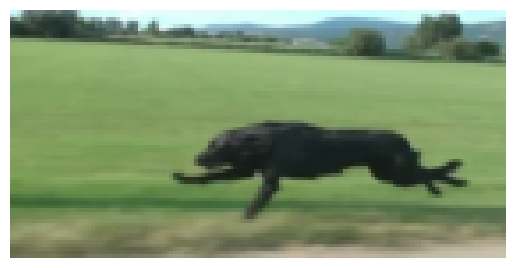

In [148]:
import cv2
video_path = 'sample_video_dog.mp4'
video_h, video_w = get_video_dimensions(video_path)
n_patches_h, n_patches_w =  int(n_patches*video_h/video_w), int(n_patches)
patch_h, patch_w  = patch_size*n_patches_h//patch_size, patch_size*n_patches_w//patch_size


transform = transforms.Compose([
                                transforms.Resize((int(patch_size*n_patches_h),int(patch_size*n_patches_w))),
                                transforms.CenterCrop((patch_size*n_patches_h,patch_size*n_patches_w)), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                ])
n_frames = 20*4




# Define a function to preprocess frames
def preprocess_frame(frame):
    # Resize the frame to match DINOv2 input size (224x224)
    resized_frame = cv2.resize(frame, (224, 224))
    # Convert the frame to RGB
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

    rgb_frame = Image.fromarray(rgb_frame)
    normalized_frame = transform(rgb_frame)
    # Add batch dimension
    normalized_frame = normalized_frame.unsqueeze(0)
    return normalized_frame

# Load the video

cap = cv2.VideoCapture(video_path)

# Process each frame of the video
frame_count = 0
total_features  = []
input_frames = []
with tqdm(total=n_frames) as pbar:
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret:
          img_t = preprocess_frame(frame)
          img_t = img_t.to(device)
          with torch.no_grad():
            features_dict = dinov2_vitl14.forward_features(img_t)
          features = features_dict['x_norm_patchtokens'].detach().cpu()
          total_features.append(features)
          input_frames.append(img_t.detach().cpu())
          frame_count += 1
          pbar.update(1)
          if len(total_features)==n_frames:
            break
      else:
          break

total_features = torch.cat(total_features, dim=0)
input_features = torch.cat(input_frames, dim=0)
total_features.shape
# Convertensort the tensor to a NumPy array
img = img_t[-1].permute(1, 2, 0).cpu().numpy()
from matplotlib import pyplot as plt
# Plot the image
print(img.shape)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

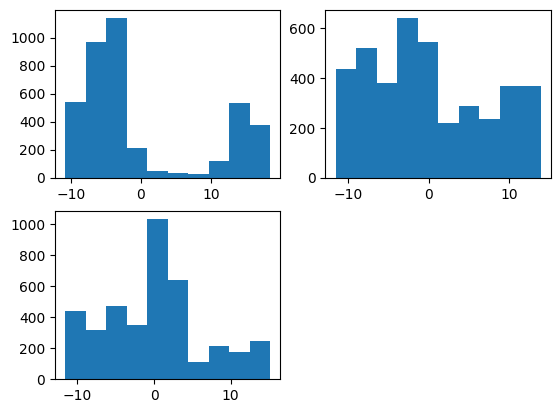

In [149]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(n_frames * patch_h*patch_w, feat_dim).detach().cpu() #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

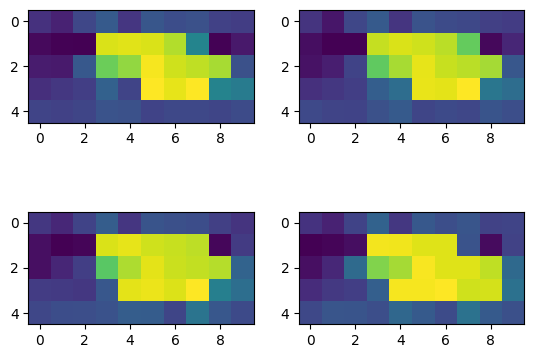

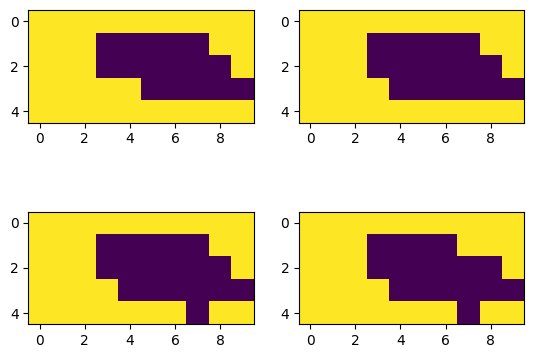

In [150]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
# pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

import numpy as np
threshold = np.median(pca_features[:, 0])

# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] < 1.5*threshold # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


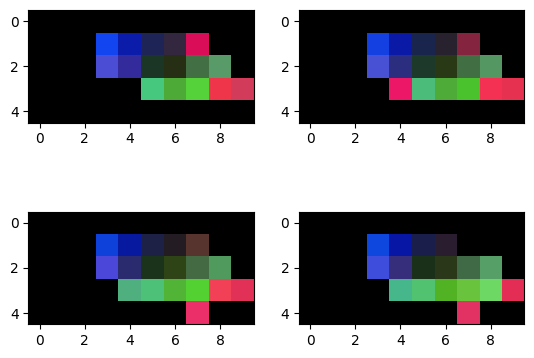

In [151]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg])
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(n_frames, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()


In [152]:
# Define the transformation function to convert float tensor in [0, 1] to int8 tensor in [0, 255]
def float_to_int8(image):
    return (image * 255).permute(1, 2, 0).numpy().astype(np.uint8)

# Assuming 'tensor' is your torch tensor with dtype=float64 and values in the range [0, 1]
# Shape of the tensor: [batch_size, channels, height, width]
tensor = torch.rand(1, 3, 224, 224)  # Example tensor


# Scale so that minimum edge is around 400px
scale = 400/max(n_patches_w,n_patches_h)

# Define the transform
transform_to_int8 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((int(n_patches_h*scale), int(n_patches_w*scale)),interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: float_to_int8(x)),

])


In [153]:
dino_frames = np.array([transform_to_int8(frame) for frame in pca_features_rgb])
input_frames = np.array([transform_to_int8(frame) for frame in input_features])

frames =  np.concatenate((input_frames,dino_frames),axis=2)

In [154]:
import imageio
# converted_images = np.clip(transform_to_int8(pca_features_rgb), 0, 255)
imageio.mimsave('./animation.gif', frames, fps=10)


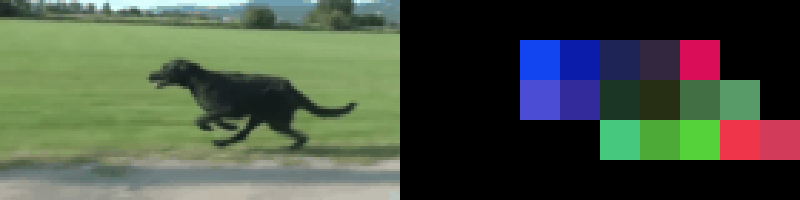

In [156]:
from IPython.display import Image as ImageDisplay
ImageDisplay('./animation.gif')